In [ ]:
!pip install scanpy
!pip install kneed

In [ ]:
!pip install leidenalg

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading and exploring data

In [3]:
adata = sc.read_10x_mtx('/content/drive/MyDrive/', var_names = 'gene_symbols', cache = True)

In [4]:
adata #vars are genes, which are 13136 in number
      # obs are cells, which are 13624 in number

AnnData object with n_obs × n_vars = 13624 × 13136
    var: 'gene_ids'

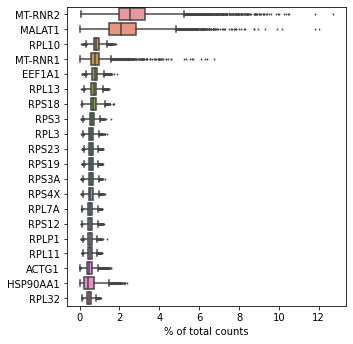

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20, )

# Preprocessing data

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [7]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') #to filter out mitochondrial genes

In [8]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

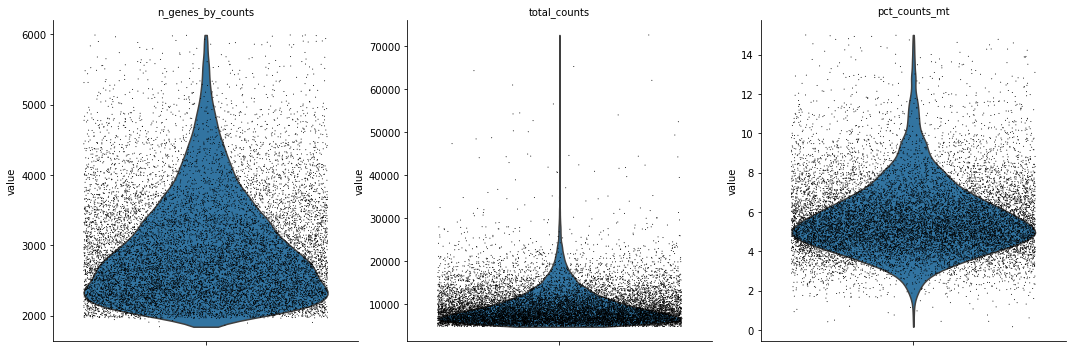

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

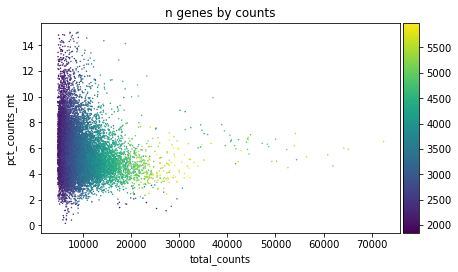

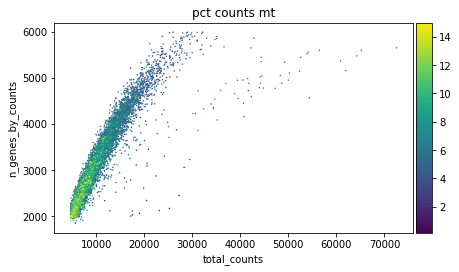

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color  = 'n_genes_by_counts')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color = 'pct_counts_mt') 
#PLOTS BEFORE FILTERING

In [11]:
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]

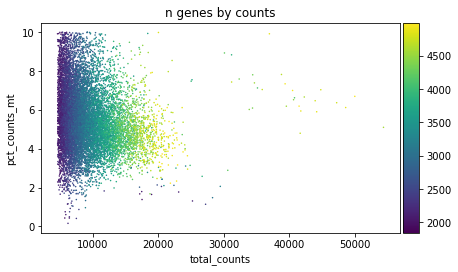

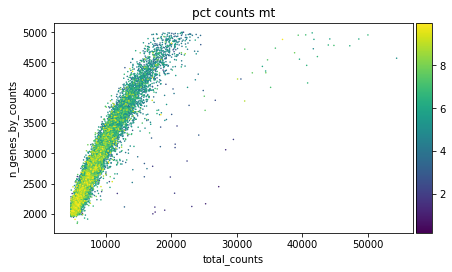

In [12]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color  = 'n_genes_by_counts')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color = 'pct_counts_mt')
#PLOTS AFTER FILTERING

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [14]:
sc.pp.log1p(adata, base = 10)

In [15]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

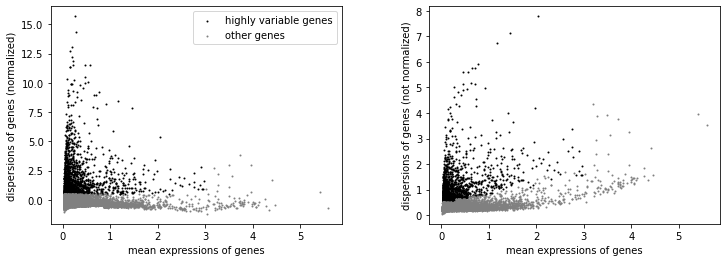

In [16]:
sc.pl.highly_variable_genes(adata) #identify only the biologically variable genes and technically variable genes

In [17]:
adata.raw = adata

In [18]:
adata = adata[:, adata.var.highly_variable]

In [19]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Linear dimensionality reduction : PCA

In [20]:
sc.pp.scale(adata, max_value=10)

In [21]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=55) #each PC is determined by some combinations of genes

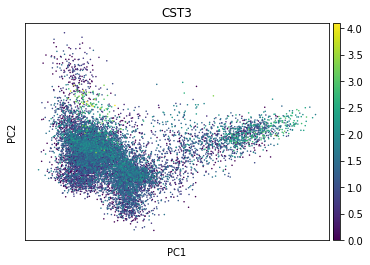

In [24]:
sc.pl.pca(adata, color='CST3') #ONE CAN NOW COLOR WITH ANY GENE (of biological importance) TO VISUALISE ITS EXPRESSION 

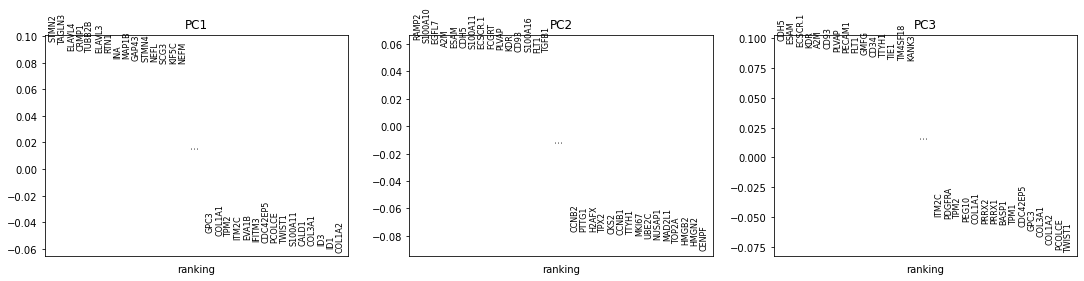

In [25]:
# sc.pl.pca_loadings(adata, components = [i+1 for i in range (adata.obsm['X_pca'].shape[1])])
sc.pl.pca_loadings(adata, components = [i+1 for i in range (3)]) #loading are the scores of each gene in every PC

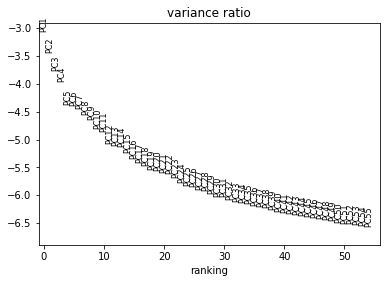

In [26]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = adata.obsm['X_pca'].shape[1])

In [28]:
from kneed import KneeLocator
def PCA_Elbow_fit(data):
    tmp = PCA()
    model = tmp.fit(data)
    explained_variance = model.explained_variance_ratio_
    pcs = list(range(1, explained_variance.shape[0]+1))
    klm = KneeLocator(pcs, explained_variance, S=1.0, curve='convex', direction='decreasing')
    pcs_used = klm.knee
    pcs_used = 23
    pc_list = list(range(1, pcs_used+1))
    new_data = PCA(n_components = pcs_used, svd_solver = "arpack").fit_transform(data)
    return pcs_used, new_data, pcs, explained_variance, pc_list

In [29]:
label = "adata"
new_frame = pd.DataFrame (adata.X, index=adata.obs_names, columns=adata.var_names) 
pandas_data=new_frame.values
dim, new_matrix,pc_ax,pc_ay,col_labels=PCA_Elbow_fit(pandas_data)

In [30]:
columns = ["PC_" + str(i) for i in col_labels]
PC_frame = pd.DataFrame(new_matrix, index=new_frame.index.values.tolist(), columns=columns)
PC_frame

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22,PC_23
AAACCCACAACCGTGC,18.797674,0.141516,1.704452,0.135572,0.571974,-1.490668,-0.130009,-0.882645,-1.993961,-3.756850,...,5.351462,-11.999744,-8.449847,2.231294,3.992940,-3.318326,3.144516,3.498181,0.853309,0.687127
AAACCCACAAGAAATC,-2.024892,0.441838,-1.445608,-2.972350,-2.199315,-4.301296,2.522109,-1.122673,1.494326,-0.494398,...,-4.756955,1.484784,-1.036724,3.313115,2.999558,3.324333,-0.323315,-0.895717,-0.243172,-0.229850
AAACCCACACGGTGCT,-1.843678,5.278519,-4.609570,-7.619237,17.731327,-4.006487,-2.525411,2.510687,2.646810,-0.281135,...,-5.235122,1.096736,0.568961,-0.344271,-3.541872,1.278329,-1.840858,-1.231672,2.025986,1.691710
AAACCCACAGTTCCAA,-2.827274,-1.973922,-2.003065,-2.028166,-3.034032,-2.458781,-2.910356,-1.114463,1.257776,-1.657556,...,-1.155154,1.044159,-3.719442,1.035895,4.685791,2.739923,-2.100071,-0.542731,-0.145666,-0.753856
AAACCCACATGAATCC,-0.702072,0.653762,3.348919,-6.038208,-1.973381,-4.222130,7.034926,0.166083,-3.222633,14.875047,...,3.631366,-0.285126,-1.090723,-0.473597,-2.532188,-2.072707,-2.144894,-0.974002,0.807136,-1.377483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCAGTGGGA,16.139164,11.305515,-7.926130,-8.447745,30.916588,-3.108476,-5.082194,5.011958,6.619409,2.343290,...,-0.621789,2.593993,0.342211,-1.932963,5.588613,2.900024,-0.791006,-2.346541,3.596224,3.041568
TTTGTTGTCCGTTGAA,-1.964210,4.681920,0.387288,-8.315557,-0.081326,11.460556,7.245721,-3.986222,0.099898,-0.348187,...,-2.043319,1.505811,-0.103051,-1.488841,1.695634,0.621606,-0.390729,-0.796791,-2.724214,2.432534
TTTGTTGTCGCGCTGA,7.006707,-8.161222,7.552514,-6.126167,0.322176,-1.645491,-3.381797,-0.155454,-1.571466,0.640068,...,-1.361434,2.802655,0.801251,-2.816374,1.220293,3.118390,-0.861978,1.788516,-0.544527,-1.415935
TTTGTTGTCGTAGTCA,-8.137922,7.012223,1.590499,2.106009,-4.095692,-2.168090,-6.417954,7.405296,-5.240389,-2.612001,...,-1.007094,-5.396898,6.116025,0.234455,-1.565019,1.701014,-0.946485,-2.545790,0.491520,-3.365002


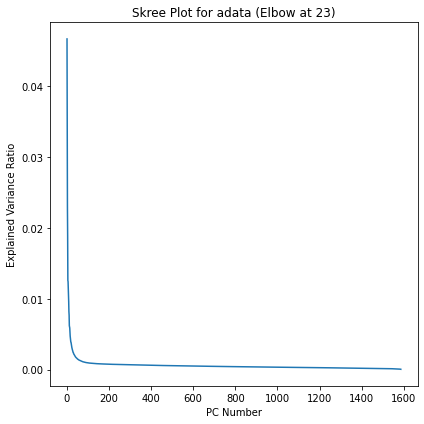

In [31]:
fig= plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_title("Skree Plot for "+label+" (Elbow at "+str(dim)+")") 
ax1.plot(pc_ax, pc_ay)
ax1.set_xlabel("PC Number")
ax1.set_ylabel("Explained Variance Ratio")
fig. tight_layout()

In [ ]:
!mkdir write
results_file = 'write/RESULTS.h5ad'
adata.write(results_file)

In [4]:
%cd "/content/drive/MyDrive/" 
results_file = 'write/RESULTS.h5ad'
adata = sc.read(results_file)

/content/drive/MyDrive


In [7]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


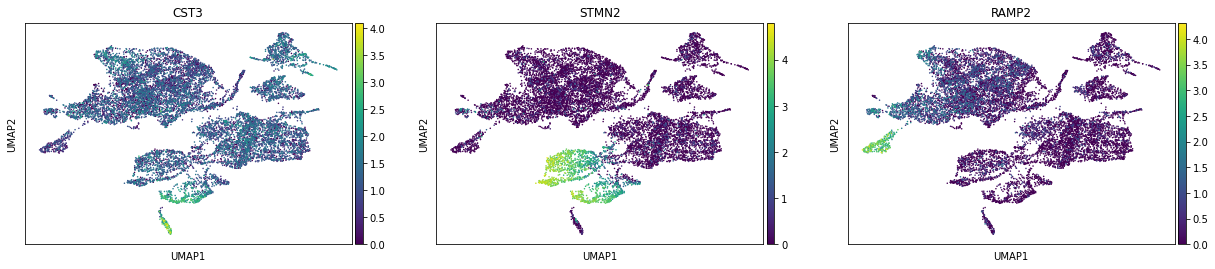

In [8]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=['CST3', 'STMN2', 'RAMP2']) #REPLACE/ADD THE NAME OF THE GENE TO VISUALISE ITS GENE EXPRESSION

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


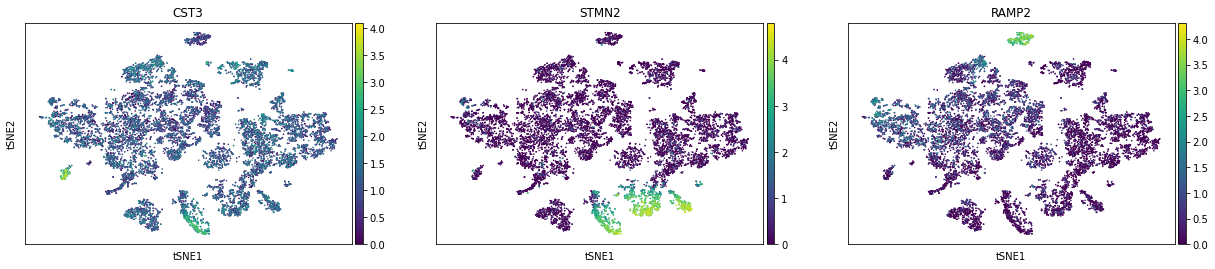

In [9]:
sc.tl.tsne(adata, n_pcs = 20)
sc.pl.tsne(adata, color=['CST3', 'STMN2', 'RAMP2']) #REPLACE/ADD THE NAME OF THE GENE TO VISUALISE ITS GENE EXPRESSION

In [12]:
sc.tl.leiden(adata, resolution = 0.5)

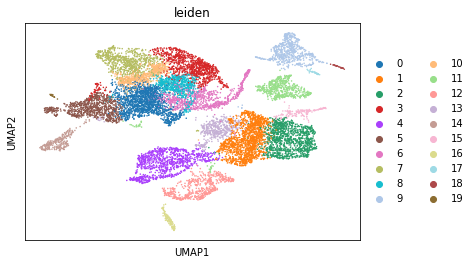

In [13]:
sc.pl.umap(adata, color=['leiden'])

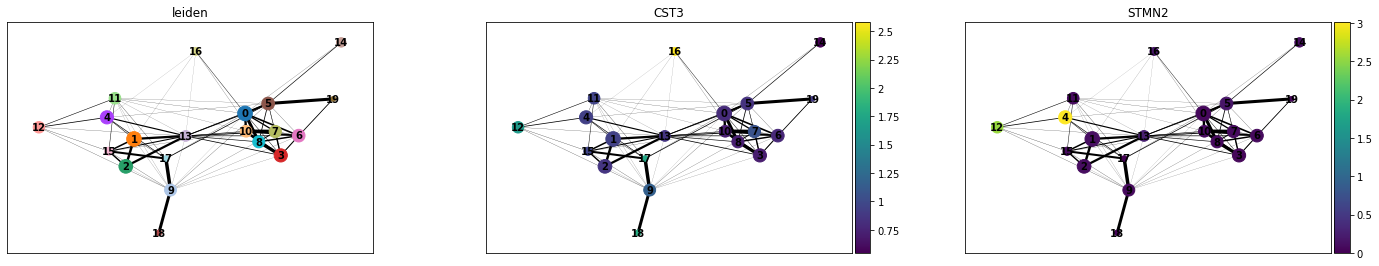

In [14]:
sc.tl.paga(adata, groups='leiden')
sc.pl.paga (adata, color=['leiden', 'CST3', 'STMN2'])

In [15]:
# sc.tl.draw_graph(adata, init_pos='paga') 
# sc.pl.draw_graph(adata, color=['leiden', 'CST3', 'STMN2'], legend_loc='on data')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


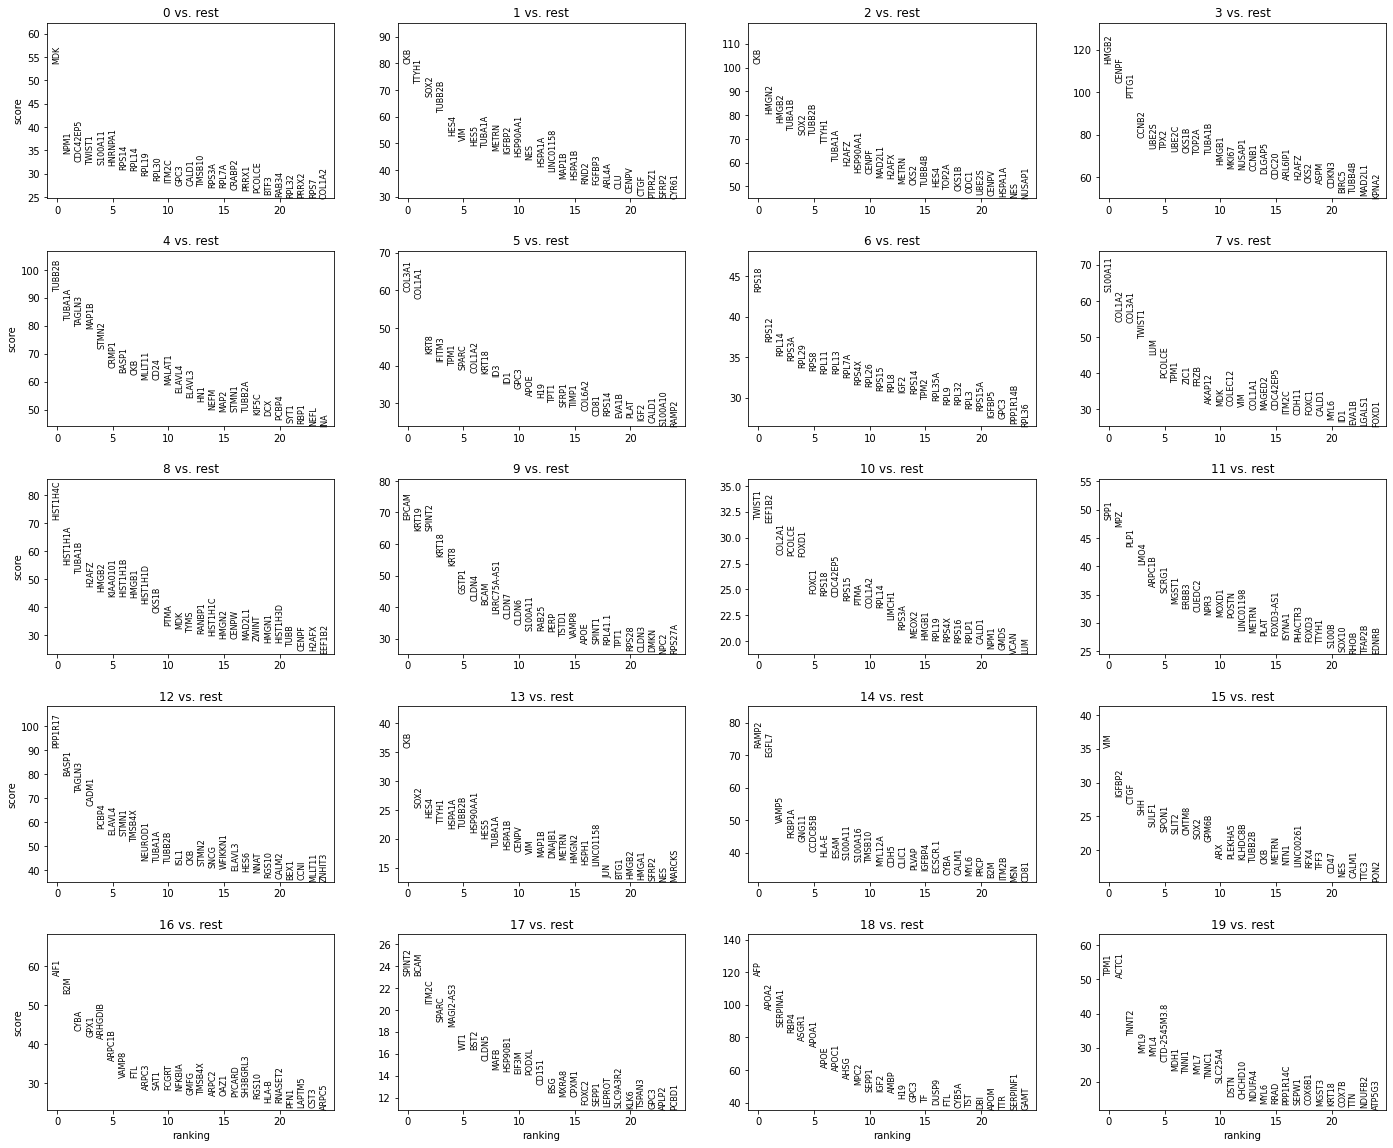

In [16]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [17]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:24)


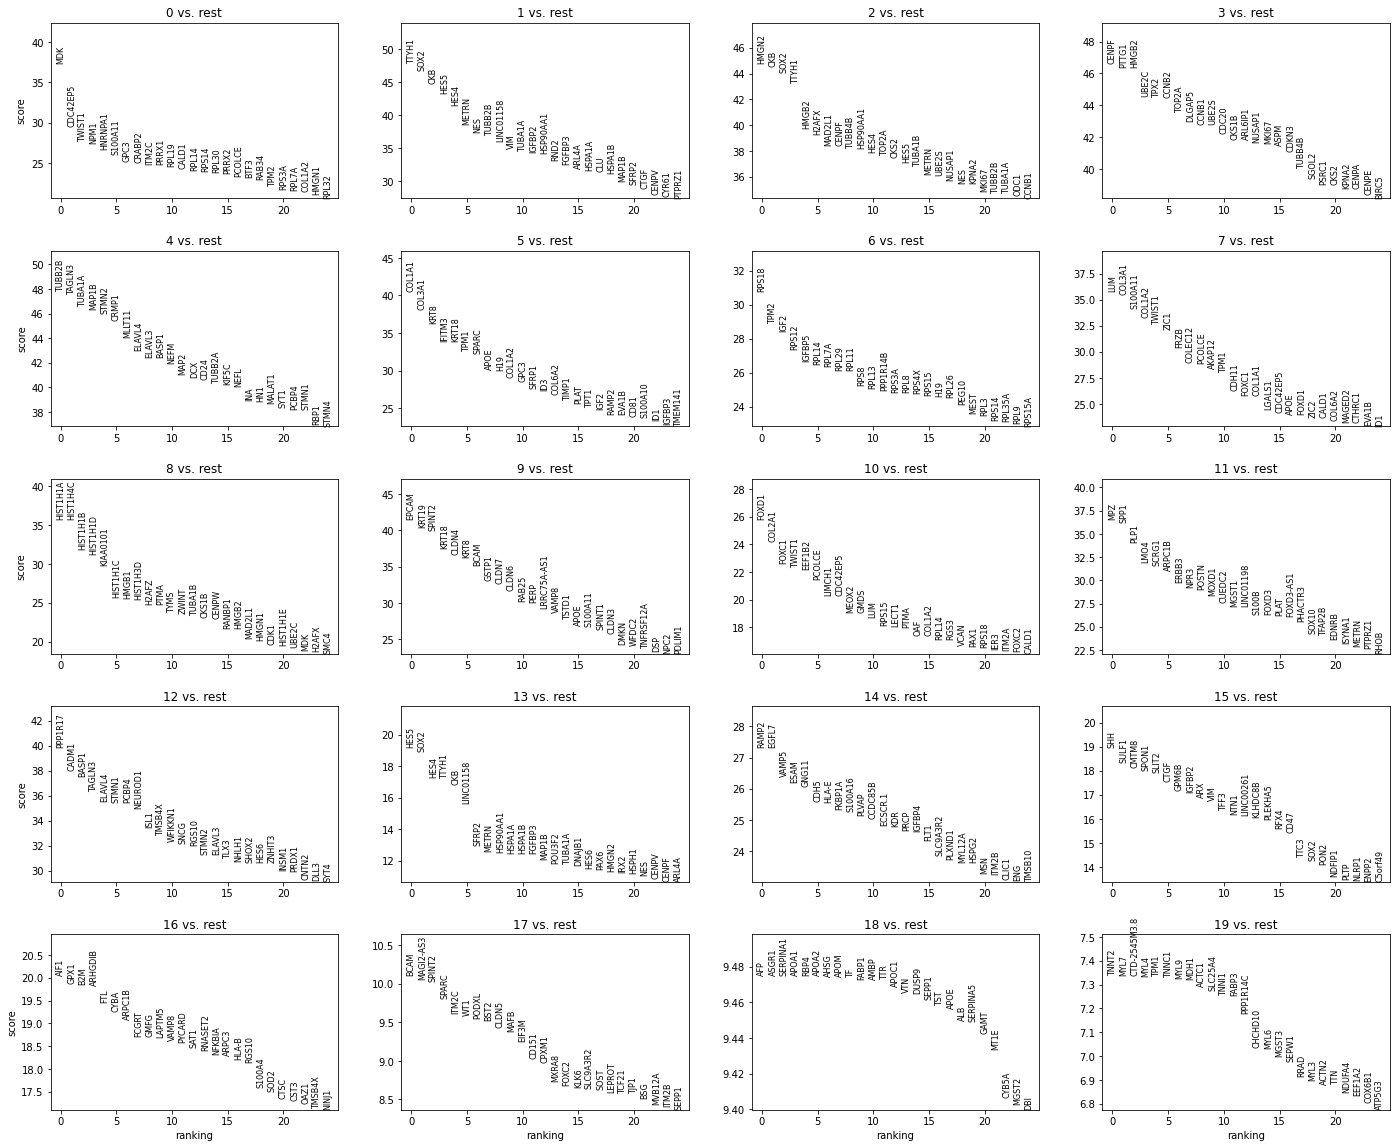

In [25]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [20]:
adata.write(results_file)

In [21]:
adata = sc.read(results_file)

In [22]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']) #ranking of the genes per cluster

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,S100A11,HES5,CKB,CENPF,STMN2,KRT18,IGFBP5,LUM,HIST1H4C,KRT19,FOXD1,SPP1,PPP1R17,CKB,RAMP2,CMTM8,CCL4,BCAM,APOA2,MYL7
1,VCAN,TTYH1,TTYH1,PTTG1,TAGLN3,KRT8,TPM2,S100A11,HIST1H1A,EPCAM,GMDS,MPZ,SNCG,HES5,EGFL7,CTGF,CCL4L1,BST2,SERPINA1,ACTC1
2,PRRX1,SOX2,SOX2,CCNB2,CRABP1,COL1A1,TNNT1,COL3A1,HIST1H1B,CLDN4,COL2A1,PLP1,CADM1,HES4,GNG11,SPON1,AIF1,CTGF,AFP,TNNT2
3,CALD1,HES4,CENPF,HMGB2,NEFM,GPC3,ACTC1,MSX1,KIAA0101,S100A11,MEOX2,LMO4,S100A10,HES6,S100A16,SHH,SPP1,IGFBP7,APOA1,TNNC1
4,CRABP2,CKB,HMGB2,UBE2C,NEFL,COL3A1,MYLPF,ZIC1,CRABP2,SPINT2,TWIST1,POSTN,RGS10,TTYH1,VAMP5,SULF1,CCL3,PODXL,ALB,MYL4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13131,MAP1B,TMSB10,TMSB10,TUBB2B,SIX1,HSP90AA1,HSPA1A,CDH2,ZIC1,TPM2,KRT8,TWIST1,TPM2,COL18A1,METRN,COL1A2,CALD1,HIST1H4C,TUBB,JUND
13132,TTYH1,COL3A1,TWIST1,SOX2,ID1,CRABP1,VCAN,CKB,VIM,RBP1,CRABP2,S100A11,VIM,HIST1H1D,HMGN2,GPC3,GPC3,TUBB,STMN1,HSPA1B
13133,METRN,HIST1H4C,COL3A1,HES4,PTN,NNAT,S100A11,CD24,SOX2,TUBA1A,TUBA1A,BASP1,CTGF,SAT1,GPC3,PTN,ID1,BASP1,TUBA1A,DNAJB1
13134,ZIC1,TWIST1,COL1A2,TTYH1,ID3,HSPA1A,ID4,GPC3,MAP1B,HSPA1A,TUBB2B,GPC3,ID1,GSTP1,CTGF,S100A11,ID3,TUBA1A,TUBA1B,ACTG1


In [27]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']})
#get the actual scores with ranks for each cluster

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,15_n,15_p,16_n,16_p,17_n,17_p,18_n,18_p,19_n,19_p
0,MDK,4.701917e-306,TTYH1,0.000000e+00,HMGN2,0.000000e+00,CENPF,0.000000e+00,TUBB2B,0.000000e+00,...,SHH,2.202956e-80,AIF1,1.484181e-89,BCAM,4.667483e-24,AFP,2.655995e-21,TNNT2,2.122296e-13
1,CDC42EP5,1.815609e-192,SOX2,0.000000e+00,CKB,0.000000e+00,PTTG1,0.000000e+00,TAGLN3,0.000000e+00,...,SULF1,2.585513e-75,GPX1,6.473062e-88,MAGI2-AS3,8.055434e-24,ASGR1,2.664729e-21,MYL7,2.132340e-13
2,TWIST1,2.100628e-169,CKB,0.000000e+00,SOX2,0.000000e+00,HMGB2,0.000000e+00,TUBA1A,0.000000e+00,...,CMTM8,2.265979e-73,B2M,1.105023e-87,SPINT2,1.164836e-23,SERPINA1,2.665979e-21,CTD-2545M3.8,2.152567e-13
3,NPM1,1.694663e-166,HES5,0.000000e+00,TTYH1,0.000000e+00,UBE2C,0.000000e+00,MAP1B,0.000000e+00,...,SPON1,1.439261e-72,ARHGDIB,1.201407e-87,SPARC,1.062905e-22,APOA1,2.665979e-21,MYL4,2.189452e-13
4,HNRNPA1,2.465873e-156,HES4,0.000000e+00,HMGB2,0.000000e+00,TPX2,0.000000e+00,STMN2,0.000000e+00,...,SLIT2,9.346217e-72,FTL,2.215262e-84,ITM2C,6.516669e-22,RBP4,2.668481e-21,TPM1,2.193589e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13131,TUBA1A,1.221140e-167,TWIST1,1.797386e-222,RPS14,3.497783e-224,FTL,2.456163e-79,EEF1B2,1.227350e-280,...,RPL37,6.445331e-30,NGFRAP1,8.540395e-59,RPS12,7.838001e-17,TUBB,4.162527e-20,RPS3,3.151245e-11
13132,MAP1B,1.122057e-172,PCOLCE,2.277456e-223,COL1A2,1.783333e-226,TUBB2B,1.871166e-82,NPM1,8.195864e-282,...,RPS23,3.772172e-30,CNN3,7.854572e-61,RPS4X,5.708738e-17,TUBA1A,2.291760e-20,RPS19,2.783645e-11
13133,CALM2,5.680890e-178,COL1A2,8.552759e-288,TPT1,1.691903e-245,EEF2,5.706772e-84,MDK,7.033313e-291,...,EEF1B2,4.330349e-32,HNRNPA1,2.623756e-62,RPS15,5.164837e-17,STMN1,1.323251e-20,PTMA,2.065177e-11
13134,TUBB4B,1.974391e-183,S100A11,8.262764e-309,S100A11,9.927391e-248,FTH1,4.175084e-96,RPL41.1,5.430196e-297,...,PTMA,9.702365e-38,MDK,1.585475e-64,RPL13,3.568543e-17,HNRNPA1,1.212266e-20,MARCKSL1,1.644820e-11


ranking genes
    finished (0:00:05)


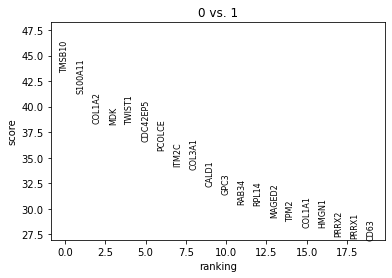

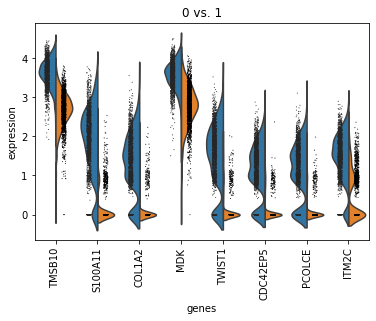

In [29]:
#If we want to compare one cluster with another
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20) 
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

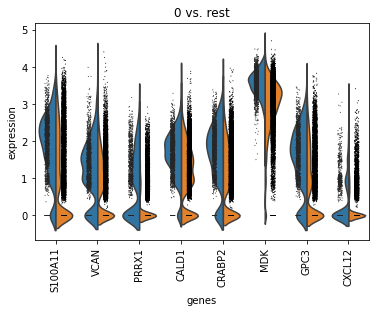

In [30]:
adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

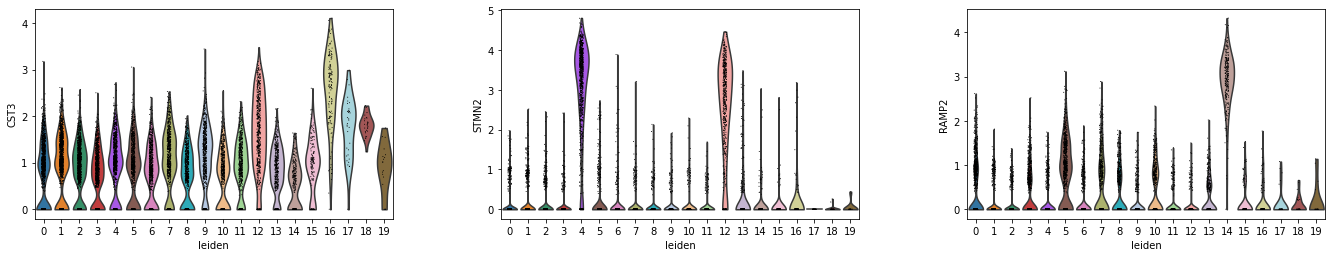

In [32]:
#comparing a certain gene across clusters
#sc.pl.violin(adata, ['CST3', 'STMN2', 'RAMP2'], groupby='leiden', n_genes=8)

In [ ]:
#We can set the cluster names according to biological significance as follows

# new_cluster_names = [
#     'CD4 T', 'CD14 Monocytes',
#     'B', 'CD8 T',
#     'NK', 'FCGR3A Monocytes',
#     'Dendritic', 'Megakaryocytes'] 

# adata.rename_categories('leiden', new_cluster_names)
# # new_cluster_names

In [33]:
adata.obs['leiden'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19'],
      dtype='object')

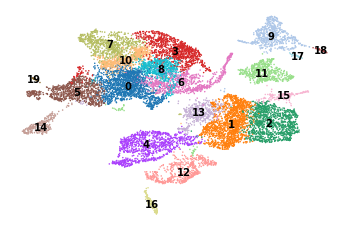

In [34]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

In [35]:
#mark important genes as marker genes 
#taken some random genes for now
marker_genes = ['CKB', 'HMGB2', 'MDK', 'TWIST1', 'EPCAM', 'RPS18', 'SPP1', 'NEFL', 'VIM', 'AIF1', 'H19', 'APOA2', 'TPM1', 'ACTC1']

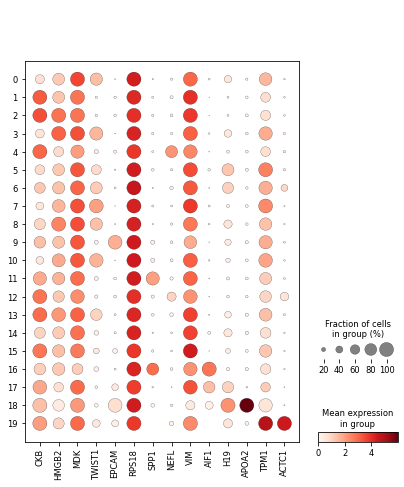

In [36]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

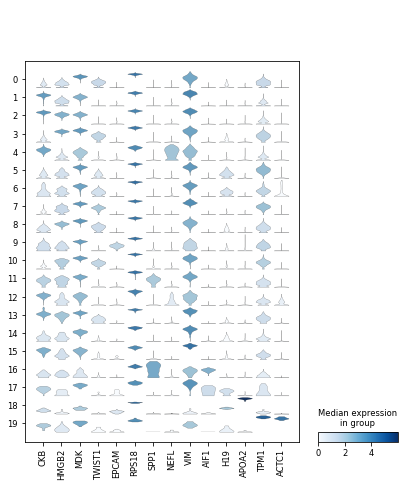

In [37]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);